# Detecting breast cancer metastases

You can find the description of my approach in more details in my other notebook. In summary, my objective is to build a tile classifier using the annotated patients, and a patient classifier by using the predictions of the tile classifier on non-annotated patients.

In this notebook, I try to build the **tile classifier** using a CNN. I will go over later what went wrong.  

I used this [research](https://www.mdpi.com/1424-8220/20/16/4373) as direction for my work. Obviously I wasn't going to implement their model since I had neither the time nor the ressources but it would be interesting to see how it would perform on our data.

*PS: This was made on google colab so you won't be able to run it since it uses the data of my Drive.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
import matplotlib as mpl
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

### Unzip

In [ ]:
os.listdir('/content/drive/MyDrive/Datasets/Owkin_2nd_Challenge')

['test_input.zip', 'train_input']

In [ ]:
os.mkdir('data')
os.listdir()

['.config', 'drive', 'data', 'sample_data']

In [ ]:
# !unzip -qq '/content/drive/MyDrive/Datasets/Owkin_2nd_Challenge/test_input_OWKIN_L914HNd.zip' -d 'data'

In [ ]:
!unzip -qq '/content/drive/MyDrive/Datasets/Owkin_2nd_Challenge/train_input/images.zip' -d 'data/train_input'

In [ ]:
# !unrar x '/content/drive/MyDrive/Datasets/Owkin_2nd_Challenge/train_input.rar' 'data/train_input' -idq

In [ ]:
os.listdir('data')

['train_input']

In [ ]:
os.listdir('data/train_input')

['images']

In [ ]:
# %rm -rf 'data'

### Looking at the data

In [ ]:
train_directory = "data/train_input/"
test_directory = "data/test_input/"

In [ ]:
annot = pd.read_csv('/content/drive/MyDrive/Datasets/Owkin_2nd_Challenge/train_input/train_tile_annotations.csv')
annot.columns = ['Info', 'Target']
print("Shape : ", annot.shape)
annot.head()

Shape :  (10124, 2)


,Info,Target
0,ID_387_annotated_tile_0_15_69_30.jpg,0.0
1,ID_387_annotated_tile_1_15_23_53.jpg,0.0
2,ID_387_annotated_tile_2_15_58_20.jpg,0.0
3,ID_387_annotated_tile_3_15_67_12.jpg,0.0
4,ID_387_annotated_tile_4_15_57_20.jpg,0.0


In [ ]:
annot['Target'].value_counts()

0.0    9417
1.0     707
Name: Target, dtype: int64

In [ ]:
class_ratio = annot['Target'].value_counts()[1] / annot['Target'].value_counts()[0]
class_ratio

0.07507698842518849

We can see here that the data is very imbalanced.

(224, 224)


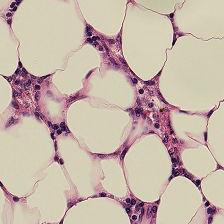

In [ ]:
im = Image.open(train_directory + "images/ID_387_annotated/ID_387_annotated_tile_0_15_69_30.jpg")
print(im.size)
im

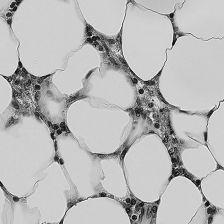

In [ ]:
im.convert('L')

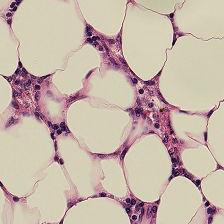

In [ ]:
im.convert('RGB')

### Training & Validation Data

#### Loading data

In [ ]:
train_images_dir = train_directory + "images/"

In [ ]:
data = []
for i in range(annot.shape[0]):
    im_path = annot.iloc[i,0]
    data.append(np.array(Image.open(train_images_dir + "ID_" + im_path[3:6] + "_annotated/" + im_path).convert('RGB')))
data = np.array(data)
print(data.shape)

(10124, 224, 224, 3)


In [ ]:
y = np.array(annot.Target)

#### Splitting data  

I used *stratify* to make sure our positive class is split accordingly between the train and test set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8099, 224, 224, 3) (2025, 224, 224, 3) (8099,) (2025,)


#### Standardization

In [ ]:
# mean = X_train.mean()
# std = X_train.std()
# X_train = (X_train - mean) / std

In [ ]:
# print('Mean: %.3f, Standard Deviation: %.3f' % (X_train.mean(), X_train.std()))

### Generator

To remedy the lack of data for a deep neural network, we use a generator that will generate batches of modified images during our training process. I also computed the class weights from our data to feed our network, so that we assign higher values in our loss function to instances of class '1'. We could've also defined and used our our own weighted loss function.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range = 0.2,
        horizontal_flip = True
)

valid_generator = ImageDataGenerator(
        rescale=1./255
)

In [ ]:
class_weights = {0: 0.5, 1: 7.0}
class_weights

{0: 0.5, 1: 7.0}

### Model  

For our model I wanted to apply transfer learning to our problem. We will load a version of the Xception model, pretrained on 'ImageNet', that we will freeze, and we will add classification layers.

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.layers

In [ ]:
# Freezing the model
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 20
history = model.fit(train_generator.flow(X_train, y_train, batch_size, seed=42), 
          epochs=epochs,
          class_weight=class_weights,
          validation_data=valid_generator.flow(X_test, y_test, batch_size, seed=42)
)

Epoch 1/20
254/254 [==============================] - 110s 392ms/step - loss: 2.6737 - accuracy: 0.7526 - val_loss: 0.6662 - val_accuracy: 0.9368
Epoch 2/20
254/254 [==============================] - 98s 387ms/step - loss: 2.7270 - accuracy: 0.7933 - val_loss: 0.4793 - val_accuracy: 0.9580
Epoch 3/20
254/254 [==============================] - 99s 389ms/step - loss: 2.2942 - accuracy: 0.7932 - val_loss: 0.2912 - val_accuracy: 0.9605
Epoch 4/20
254/254 [==============================] - 99s 388ms/step - loss: 2.5849 - accuracy: 0.9110 - val_loss: 0.4587 - val_accuracy: 0.9215
Epoch 5/20
254/254 [==============================] - 99s 389ms/step - loss: 2.2754 - accuracy: 0.7789 - val_loss: 14.1466 - val_accuracy: 0.0701
Epoch 6/20
254/254 [==============================] - 99s 388ms/step - loss: 7.1180 - accuracy: 0.0657 - val_loss: 14.1460 - val_accuracy: 0.0701
Epoch 7/20
254/254 [==============================] - 99s 388ms/step - loss: 7.0509 - accuracy: 0.0737 - val_loss: 14.1324 - va

In [ ]:
model.save("transfer_learning_model.h5")

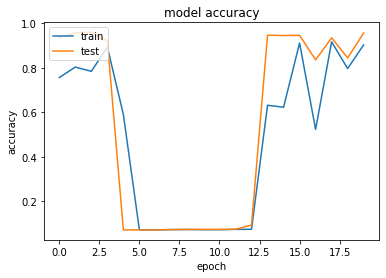

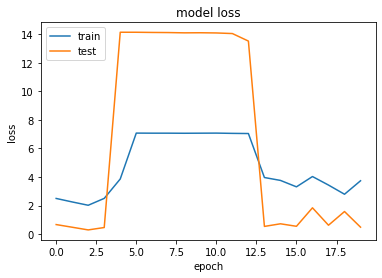

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see, the loss of our model is pretty unstable. This is due to the imbalance in our data : class weighting puts very high value on the positive sample and since our model fails to detect this, the penalty is very high. In our case, our model is probably predicting only the negative class. Let's check it out.

### Evaluation

In [ ]:
model.evaluate(X_test, y_test)

64/64 [==============================] - 9s 129ms/step - loss: 2.0598 - accuracy: 0.8548


[2.059767723083496, 0.8548148274421692]

In [ ]:
preds = model.predict(X_test, batch_size=32)
preds = preds.argmax(axis=-1)

In [ ]:
preds.shape

(2025,)

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, preds)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.5

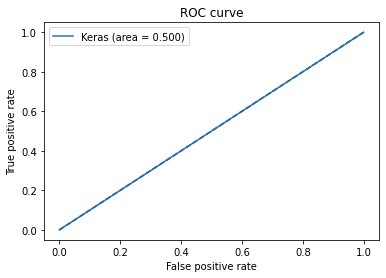

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1884
         1.0       0.00      0.00      0.00       141

    accuracy                           0.93      2025
   macro avg       0.47      0.50      0.48      2025
weighted avg       0.87      0.93      0.90      2025



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
np.unique(preds, return_counts=True)

(array([0]), array([2025]))

As we can see, our model only predicts instances of class '0', so when instances of class '1' appear during training the penality is very high thus why our training is unstable and not efficient.  

To resolve this, I would've removed the class_weight attribute and would've better handled the image generating process so that it generates even batches of both classes.  

But since I had already spent a lot of time in trying to make all this process work on Google Colab, I decided to not spend any more time on the images and build simpler models on the ResNet features.

### Sources

- [Breast Cancer Histopathology Image Classification Using an Ensemble of Deep Learning Models](https://www.mdpi.com/1424-8220/20/16/4373)